In [144]:
import pandas as pd
import numpy as np



import plotly as py
import matplotlib.pyplot as plt


from tqdm import tqdm, trange
import seaborn as sns
import random





In [6]:
df_train=pd.read_csv('train_features.csv')

In [ ]:
df_train.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,2016-01-01 00:00:00,NaN,0,0,Education,2720,104,0,19.4,...,4.116,3.981,4.146,4.12,3.569,4.489,4.079,3.554,3.538,3.845
1,32,2016-01-01 00:00:00,NaN,0,0,Office,48392,105,0,19.4,...,4.116,3.981,4.146,4.12,4.513,4.211,4.079,4.128,4.579,4.317
2,41,2016-01-01 00:00:00,NaN,0,0,Office,93860,68,0,19.4,...,4.116,3.981,4.146,4.12,4.108,4.211,4.079,4.103,4.140,4.114
3,55,2016-01-01 00:00:00,NaN,0,0,Office,16726,111,0,19.4,...,4.116,3.981,4.146,4.12,3.506,4.211,4.079,3.308,3.565,3.813
4,69,2016-01-01 00:00:00,NaN,0,0,Parking,387638,100,0,19.4,...,4.116,3.981,4.146,4.12,3.035,3.623,4.079,3.892,3.090,3.577


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749494 entries, 0 to 1749493
Data columns (total 57 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   building_id                    int64  
 1   timestamp                      object 
 2   meter_reading                  float64
 3   anomaly                        int64  
 4   site_id                        int64  
 5   primary_use                    object 
 6   square_feet                    int64  
 7   year_built                     int64  
 8   floor_count                    int64  
 9   air_temperature                float64
 10  cloud_coverage                 int64  
 11  dew_temperature                float64
 12  precip_depth_1_hr              int64  
 13  sea_level_pressure             float64
 14  wind_direction                 int64  
 15  wind_speed                     float64
 16  air_temperature_mean_lag7      float64
 17  air_temperature_max_lag7       float64
 18  ai

In [7]:
df_train_y=pd.read_csv('train.csv')

In [ ]:
df_train.value_counts('building_id')
##200 building IDs as expected

building_id
1       8784
1278    8784
1283    8784
1284    8784
1285    8784
        ... 
848     8351
844     7959
827     7799
1232    7779
1353    7471
Length: 200, dtype: int64

In [186]:
#from: https://www.kaggle.com/code/patrick0302/2-anomaly-detection-features-csv-revised-ensem
for col in df_train.columns:
    if df_train[col].nunique()==1:
        print(col, df_train[col].dtype)
#both year and gte_meter are not unique across all 


year int64
gte_meter float64


In [8]:
df_train['date'] = pd.to_datetime(df_train['timestamp']).dt.date #need to troubleshoot this?
df_train['meterReadings_daily_std'] = df_train.groupby(['building_id','date'])['meter_reading'].transform('std')
df_train = df_train.drop(['timestamp', 'year', 'gte_meter'], axis=1) #No use of columns in the modelling with only one values for all the entries.

In [190]:
#https://www.freecodecamp.org/news/python-unique-list-how-to-get-all-the-unique-values-in-a-list-or-array/
unique_buildings = list(set(df_train.building_id))
print(unique_buildings)
unique_buildings
#https://www.geeksforgeeks.org/python-converting-all-strings-in-list-to-integers/
#unique_buildings2 = [eval(i) for i in unique_buildings]
#nevermind, it's an integer already

[1, 534, 32, 41, 1068, 560, 1073, 1074, 55, 69, 79, 82, 1106, 91, 1120, 1128, 107, 108, 111, 112, 623, 1137, 117, 118, 119, 1141, 121, 1143, 1147, 136, 137, 139, 141, 653, 144, 657, 658, 147, 148, 149, 1172, 666, 667, 159, 673, 675, 677, 680, 171, 683, 173, 174, 685, 687, 181, 693, 183, 697, 698, 701, 190, 1219, 708, 710, 1225, 1226, 1230, 1232, 721, 722, 1234, 1238, 1239, 729, 730, 1241, 732, 1242, 1245, 1246, 1247, 1249, 739, 1251, 1252, 742, 1253, 1255, 1257, 1258, 235, 1259, 1260, 238, 1261, 240, 1264, 1266, 1267, 246, 247, 248, 1272, 1275, 253, 254, 1278, 1279, 1283, 1284, 1285, 263, 270, 1296, 1297, 275, 276, 1300, 278, 1302, 1303, 1304, 1306, 1309, 1310, 1311, 801, 290, 1315, 1316, 293, 1318, 1319, 1323, 312, 827, 318, 1353, 844, 335, 848, 345, 356, 879, 880, 881, 882, 884, 886, 887, 889, 890, 892, 893, 894, 895, 896, 903, 905, 909, 914, 919, 922, 924, 925, 926, 928, 929, 931, 423, 935, 936, 941, 942, 945, 948, 950, 439, 952, 961, 966, 967, 968, 969, 970, 971, 973, 974, 975, 977

[1,
 534,
 32,
 41,
 1068,
 560,
 1073,
 1074,
 55,
 69,
 79,
 82,
 1106,
 91,
 1120,
 1128,
 107,
 108,
 111,
 112,
 623,
 1137,
 117,
 118,
 119,
 1141,
 121,
 1143,
 1147,
 136,
 137,
 139,
 141,
 653,
 144,
 657,
 658,
 147,
 148,
 149,
 1172,
 666,
 667,
 159,
 673,
 675,
 677,
 680,
 171,
 683,
 173,
 174,
 685,
 687,
 181,
 693,
 183,
 697,
 698,
 701,
 190,
 1219,
 708,
 710,
 1225,
 1226,
 1230,
 1232,
 721,
 722,
 1234,
 1238,
 1239,
 729,
 730,
 1241,
 732,
 1242,
 1245,
 1246,
 1247,
 1249,
 739,
 1251,
 1252,
 742,
 1253,
 1255,
 1257,
 1258,
 235,
 1259,
 1260,
 238,
 1261,
 240,
 1264,
 1266,
 1267,
 246,
 247,
 248,
 1272,
 1275,
 253,
 254,
 1278,
 1279,
 1283,
 1284,
 1285,
 263,
 270,
 1296,
 1297,
 275,
 276,
 1300,
 278,
 1302,
 1303,
 1304,
 1306,
 1309,
 1310,
 1311,
 801,
 290,
 1315,
 1316,
 293,
 1318,
 1319,
 1323,
 312,
 827,
 318,
 1353,
 844,
 335,
 848,
 345,
 356,
 879,
 880,
 881,
 882,
 884,
 886,
 887,
 889,
 890,
 892,
 893,
 894,
 895,
 896,
 903,
 

In [ ]:
df_train.value_counts('timestamp') #8784 unique timestamps (probably 100 means one for each building) 

timestamp
2016-01-01 00:00:00    100
2016-08-28 19:00:00    100
2016-08-29 07:00:00    100
2016-08-29 06:00:00    100
2016-08-29 05:00:00    100
                      ... 
2016-07-05 05:00:00     87
2016-01-20 11:00:00     86
2016-03-13 03:00:00     86
2016-03-13 02:00:00     84
2016-03-23 16:00:00     79
Length: 8784, dtype: int64

In [ ]:
df_train.value_counts('year_built')
## the 255 values are NAs, from the dataset description,  it appears adding 1900 to these values gives the exact year built.
##probably can't impute this. But can't leave it as 255 (even though they seemed to do so in the kaggle set)

year_built
255    286941
76     105408
66      70271
19      43920
60      43919
110     35058
114     26345
104     17568
105     17568
68      17567
67      17566
64      17564
103      8784
107      8784
100      8784
111      8784
77       8784
0        8784
74       8784
6        8784
45       8784
13       8784
9        8784
89       8783
31       8783
82       8782
70       8782
92       8781
65       8781
57       8781
52       8781
30       8761
dtype: int64

In [ ]:
df_train.value_counts('cloud_coverage') ##same issue here with cloud coverage. probably best to state as missing? 
#May be able to imput here based on other vars? 
# Not appripropriate for non-decision based methods but maybe ok for others?

cloud_coverage
255    455078
0      221325
2       92850
4       66349
6       22160
8       14337
9        3235
dtype: int64

In [9]:
#this isn't ideal -Dunno why they made it a "10" in the kaggle dataset. But I'm gonna try it here 
# https://www.kaggle.com/code/patrick0302/2-anomaly-detection-features-csv-revised-ensem/notebook
df_train['cloud_coverage'] = df_train['cloud_coverage'].replace({255:10})
df_train.head()

,building_id,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month,date,meterReadings_daily_std
0,1,NaN,0,0,Education,2720,104,0,19.4,10,...,4.146,4.12,3.569,4.489,4.079,3.554,3.538,3.845,2016-01-01,NaN
1,32,NaN,0,0,Office,48392,105,0,19.4,10,...,4.146,4.12,4.513,4.211,4.079,4.128,4.579,4.317,2016-01-01,NaN
2,41,NaN,0,0,Office,93860,68,0,19.4,10,...,4.146,4.12,4.108,4.211,4.079,4.103,4.140,4.114,2016-01-01,NaN
3,55,NaN,0,0,Office,16726,111,0,19.4,10,...,4.146,4.12,3.506,4.211,4.079,3.308,3.565,3.813,2016-01-01,NaN
4,69,NaN,0,0,Parking,387638,100,0,19.4,10,...,4.146,4.12,3.035,3.623,4.079,3.892,3.090,3.577,2016-01-01,NaN


In [10]:
#dropping vars with building ID b/c I'm separating train/val/test by building ID
df_train=df_train.drop(['gte_building_id','gte_meter_building_id', 'gte_meter_building_id_hour', 'gte_meter_building_id_weekday', 'gte_meter_building_id_month','building_weekday_hour', 'building_weekday', 'building_month','building_hour','building_meter'], axis=1) 


Initial Data Exploration

In [12]:
ints = []
objects = []
floats = []

for col in df_train.columns:
    if df_train[col].dtype == int:
        ints.append(col)
    elif df_train[col].dtype == object:
        objects.append(col)
    else:
        floats.append(col)

array([[<AxesSubplot:title={'center':'building_id'}>,
        <AxesSubplot:title={'center':'anomaly'}>,
        <AxesSubplot:title={'center':'site_id'}>],
       [<AxesSubplot:title={'center':'square_feet'}>,
        <AxesSubplot:title={'center':'year_built'}>,
        <AxesSubplot:title={'center':'floor_count'}>],
       [<AxesSubplot:title={'center':'cloud_coverage'}>,
        <AxesSubplot:title={'center':'precip_depth_1_hr'}>,
        <AxesSubplot:title={'center':'wind_direction'}>],
       [<AxesSubplot:title={'center':'is_holiday'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

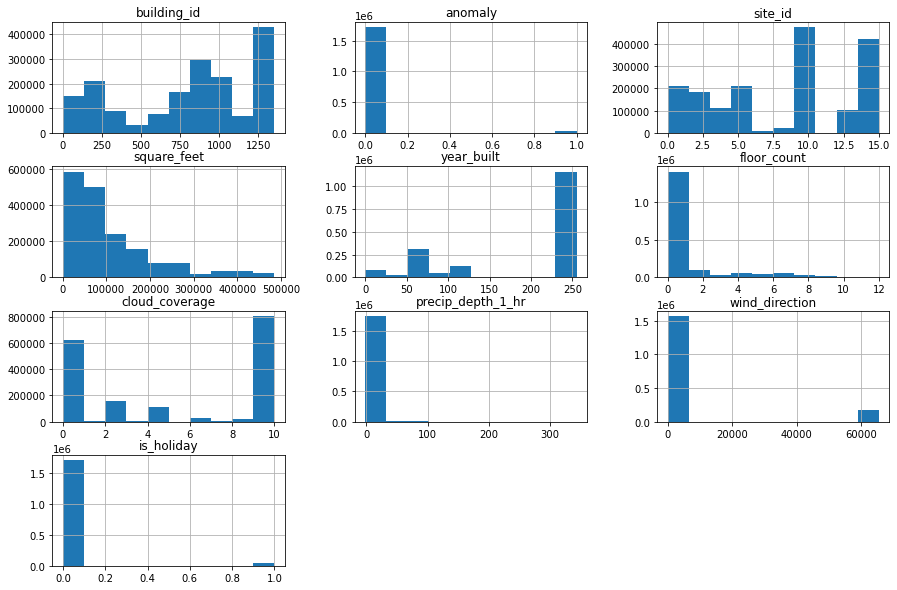

In [225]:
#https://stackoverflow.com/questions/49780491/plotting-histogram-for-all-columns-in-a-data-frame
df_train[ints].hist(figsize=(15, 10))
#building_id - remove
#anomaly - boolean
#site_id - remove
#square_feet- robust scalar?
#year built - standard is prob fine once removing outliers
#floor count - robust scalar?
#cloud_coverage - need to change 255 or put in as missing
#precipitation- can't tell if outliers or NAs
#wind direction - prob has outliers
#hour-needs to be removed (circ version created)
#weekday-needs to be removed (circ version created
#month--needs to be removed (circ version created
#is_holiday- boolean


In [194]:
df_train=df_train.drop(['weekday','hour','month'], axis=1) 


array([[<AxesSubplot:title={'center':'meter_reading'}>,
        <AxesSubplot:title={'center':'air_temperature'}>,
        <AxesSubplot:title={'center':'dew_temperature'}>,
        <AxesSubplot:title={'center':'sea_level_pressure'}>,
        <AxesSubplot:title={'center':'wind_speed'}>],
       [<AxesSubplot:title={'center':'air_temperature_mean_lag7'}>,
        <AxesSubplot:title={'center':'air_temperature_max_lag7'}>,
        <AxesSubplot:title={'center':'air_temperature_min_lag7'}>,
        <AxesSubplot:title={'center':'air_temperature_std_lag7'}>,
        <AxesSubplot:title={'center':'air_temperature_mean_lag73'}>],
       [<AxesSubplot:title={'center':'air_temperature_max_lag73'}>,
        <AxesSubplot:title={'center':'air_temperature_min_lag73'}>,
        <AxesSubplot:title={'center':'air_temperature_std_lag73'}>,
        <AxesSubplot:title={'center':'hour_x'}>,
        <AxesSubplot:title={'center':'hour_y'}>],
       [<AxesSubplot:title={'center':'month_x'}>,
        <AxesSubplot:

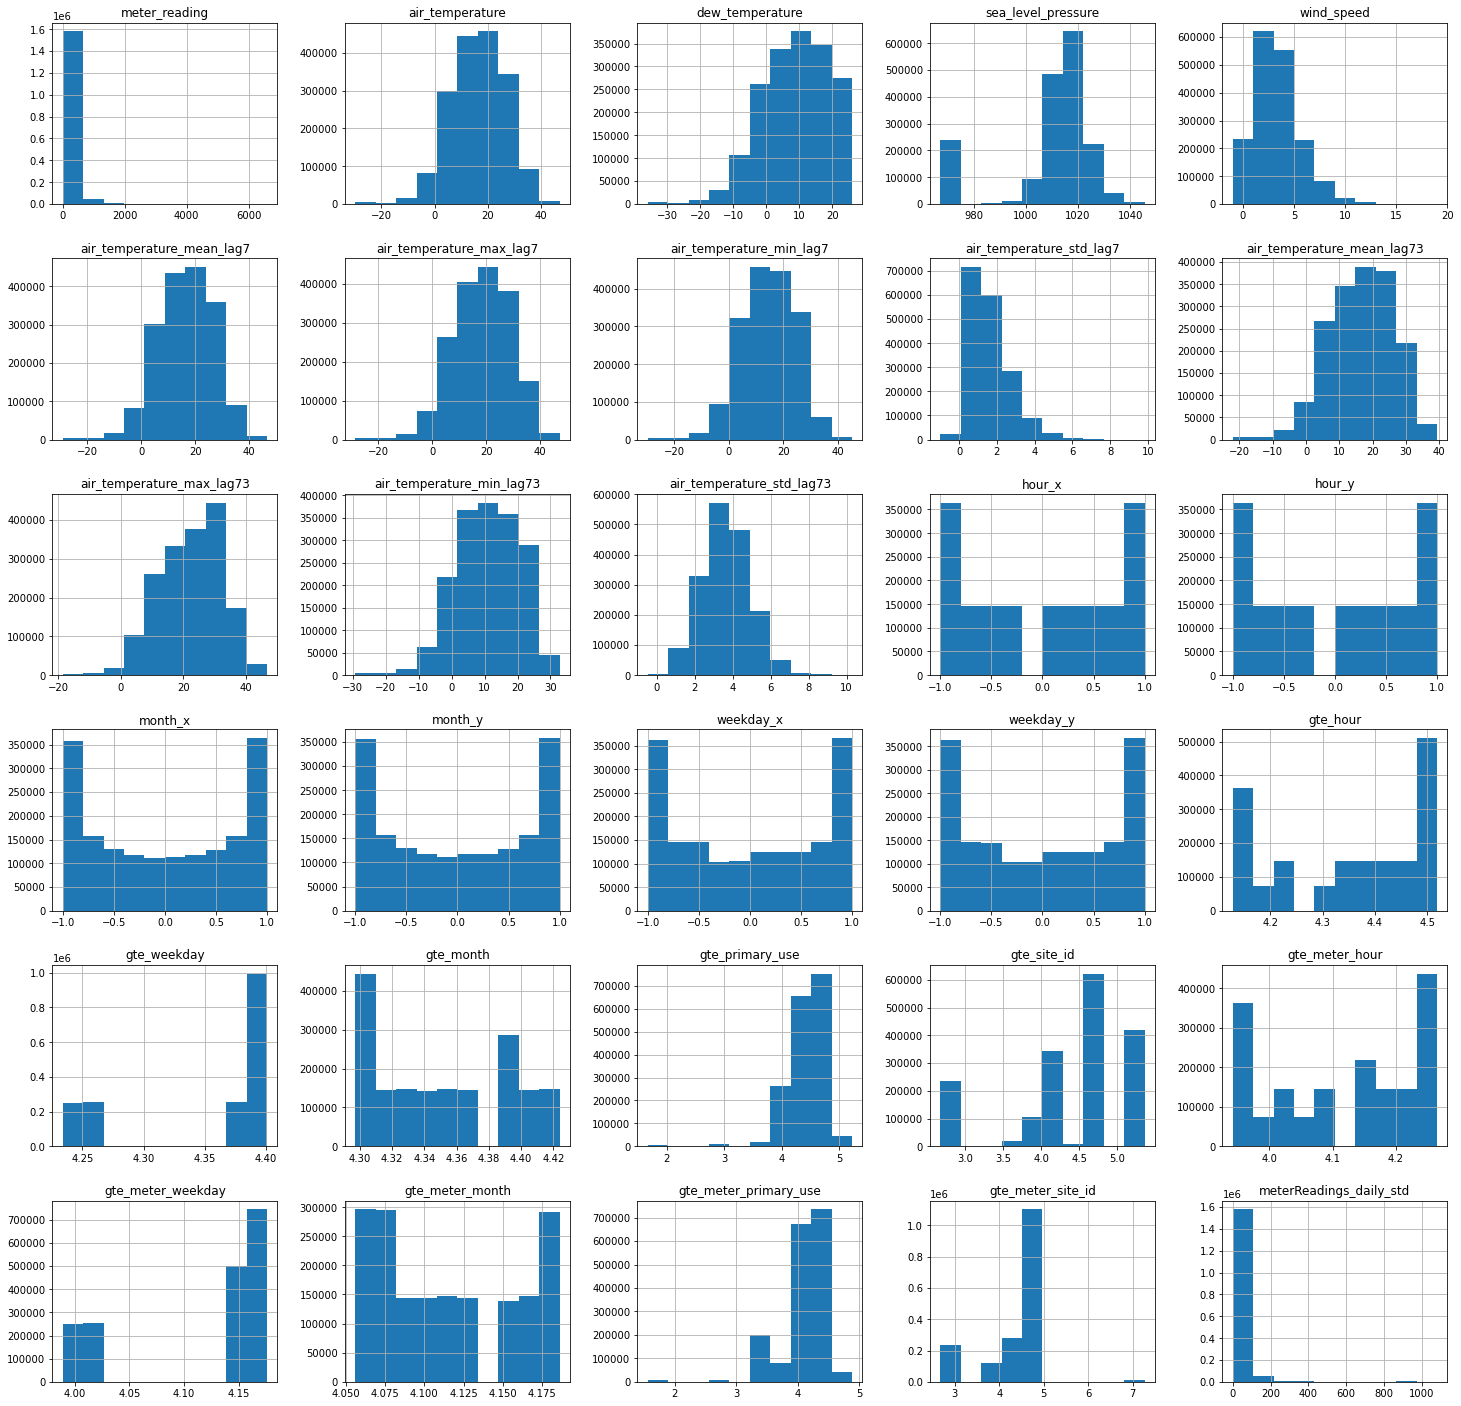

In [156]:
#https://stackoverflow.com/questions/49780491/plotting-histogram-for-all-columns-in-a-data-frame
df_train[floats].hist(figsize=(25, 25))  

In [ ]:
#try to reduce the non-anomoly target observations here and increase anomalies so we can look at feature separation

In [320]:
anomaly=df_train[df_train['anomaly']==1]
clear=df_train[df_train['anomaly']==0]

In [326]:
#https://stackoverflow.com/questions/71857224/randomly-selecting-a-subset-of-rows-from-a-pandas-dataframe-based-on-existing-co
samples = []
for group in clear.building_id.unique():
    s = clear.loc[clear.building_id== group].sample(n=500, replace=False, axis=0).reset_index(drop=True)
    samples.append(s)
    
sample = pd.concat(samples, axis=0)

In [327]:
sample_full=pd.concat([sample,anomaly], axis=0)

sample_full.head()

,building_id,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,weekday_y,is_holiday,gte_site_id,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_primary_use,gte_meter_site_id,date,meterReadings_daily_std
0,1,27.848,0,0,Education,2720,104,0,17.2,10,...,-0.989,0,4.703,3.952,4.176,4.102,4.489,4.079,2016-11-09,1.207415
1,1,29.529,0,0,Education,2720,104,0,20.0,6,...,0.400,0,4.703,3.964,4.147,4.056,4.489,4.079,2016-12-12,4.635114
2,1,NaN,0,0,Education,2720,104,0,15.6,10,...,-0.000,0,4.703,4.257,4.147,4.148,4.489,4.079,2016-02-08,NaN
3,1,37.051,0,0,Education,2720,104,0,27.2,2,...,0.400,0,4.703,4.244,4.146,4.080,4.489,4.079,2016-10-21,2.391901
4,1,38.651,0,0,Education,2720,104,0,27.2,2,...,-0.847,0,4.703,4.102,4.176,4.129,4.489,4.079,2016-06-22,0.909777


In [328]:
s_ints = []
s_objects = []
s_floats = []

for col in sample_full.columns:
    if sample_full[col].dtype == int:
        ints.append(col)
    elif sample_full[col].dtype == object:
        objects.append(col)
    else:
        floats.append(col)

In [329]:
sammple_full=pd.DataFrame(sample_full)

In [338]:

duplicate = sample_full.index.duplicated()
duplicate

#https://stackoverflow.com/questions/28663856/how-do-i-count-the-occurrence-of-a-certain-item-in-an-ndarray
unique, counts = np.unique(duplicate, return_counts=True)
dict(zip(unique, counts))


{False: 37768, True: 99528}

In [340]:
#fix index
sample_full=sample_full.reset_index()

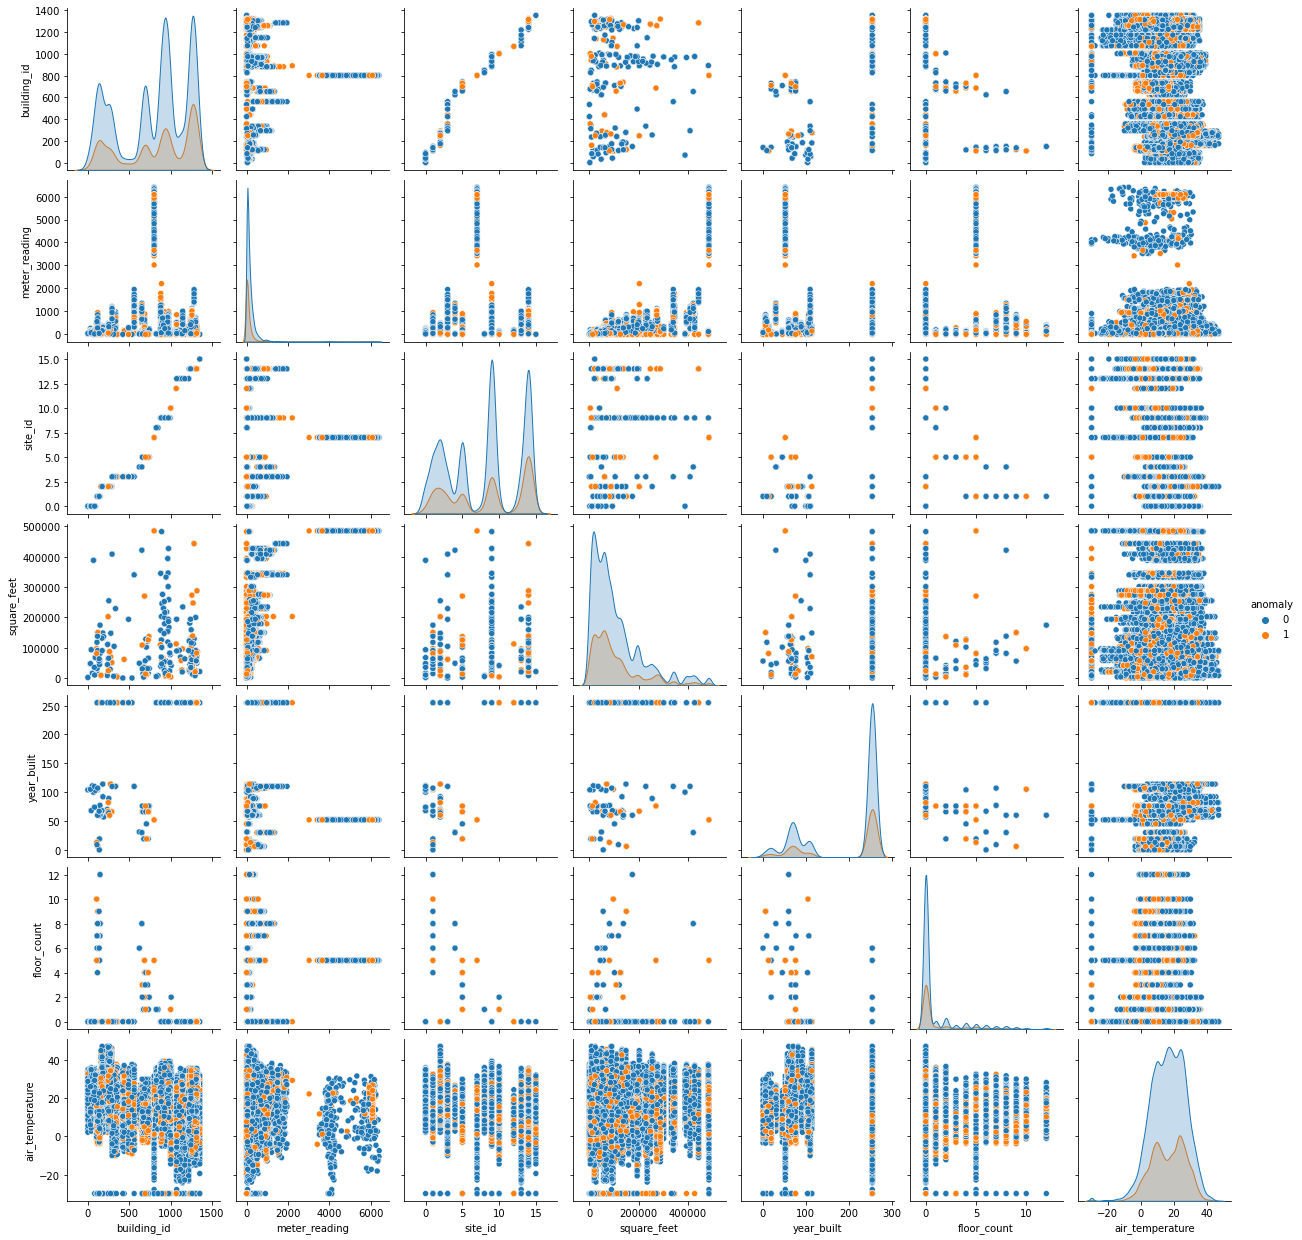

In [342]:
sns.pairplot(sample_full.iloc[:,1:10].sample(100000, replace=False, axis=0),hue='anomaly')

In [298]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   building_id                200000 non-null  int64  
 1   meter_reading              187752 non-null  float64
 2   anomaly                    200000 non-null  int64  
 3   site_id                    200000 non-null  int64  
 4   primary_use                200000 non-null  object 
 5   square_feet                200000 non-null  int64  
 6   year_built                 200000 non-null  int64  
 7   floor_count                200000 non-null  int64  
 8   air_temperature            200000 non-null  float64
 9   cloud_coverage             200000 non-null  int64  
 10  dew_temperature            200000 non-null  float64
 11  precip_depth_1_hr          200000 non-null  int64  
 12  sea_level_pressure         200000 non-null  float64
 13  wind_direction             20000

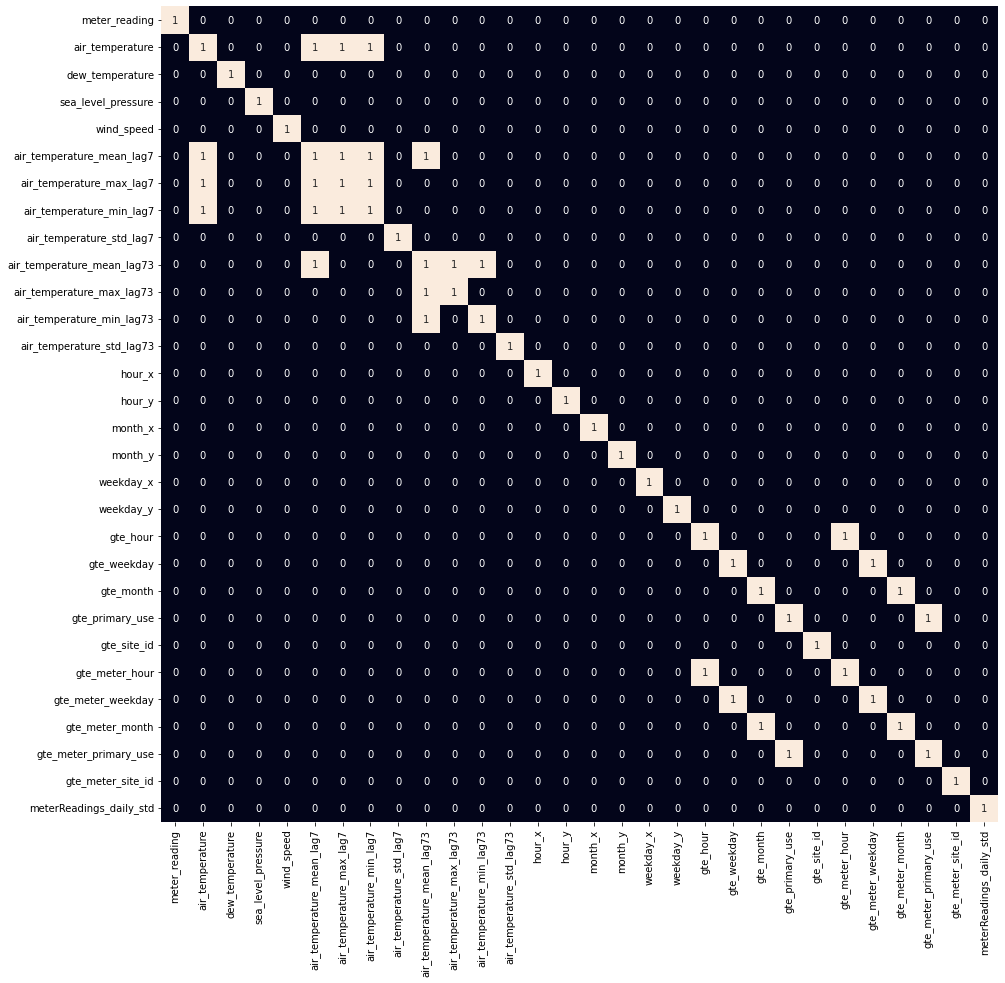

In [158]:
#https://www.kaggle.com/code/patrick0302/2-anomaly-detection-features-csv-revised-ensem
plt.figure(figsize=(15,15))
sb.heatmap(df_train[floats].corr() > 0.95, annot=True, cbar=False)
plt.show()
#need to drop those correlated to each other but one

In [66]:
df_train=df_train.drop(['gte_hour','gte_weekday','gte_month','gte_primary_use','air_temperature_max_lag7','air_temperature_min_lag7','air_temperature_max_lag73','air_temperature_min_lag73'], axis=1) 

In [67]:
df_train=df_train.drop(['air_temperature_mean_lag7','air_temperature_mean_lag73'], axis=1)

In [167]:
#https://www.kaggle.com/code/patrick0302/2-anomaly-detection-features-csv-revised-ensem
ints = []
objects = []
floats = []

for col in df_train.columns:
    if df_train[col].dtype == int:
        ints.append(col)
    elif df_train[col].dtype == object:
        objects.append(col)
    else:
        floats.append(col)

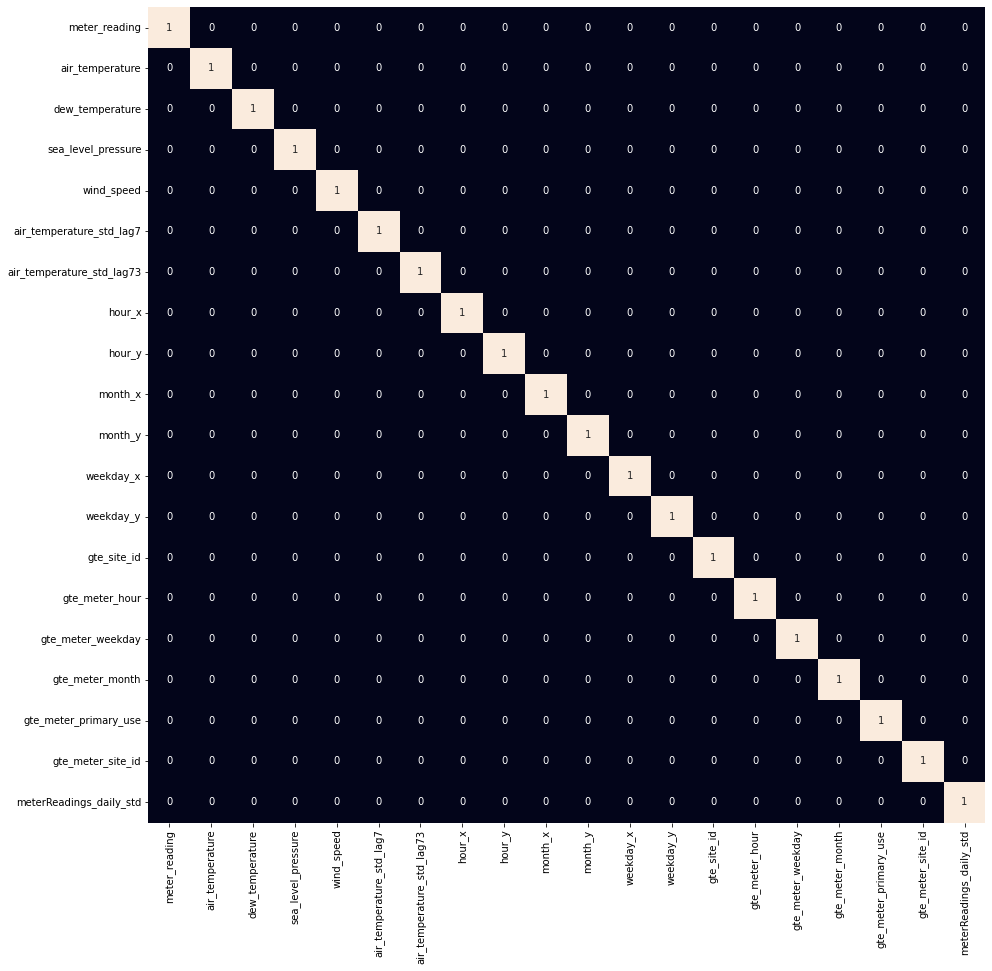

In [168]:
#https://www.kaggle.com/code/patrick0302/2-anomaly-detection-features-csv-revised-ensem
plt.figure(figsize=(15,15))
sb.heatmap(df_train[floats].corr() > 0.95, annot=True, cbar=False)
plt.show()

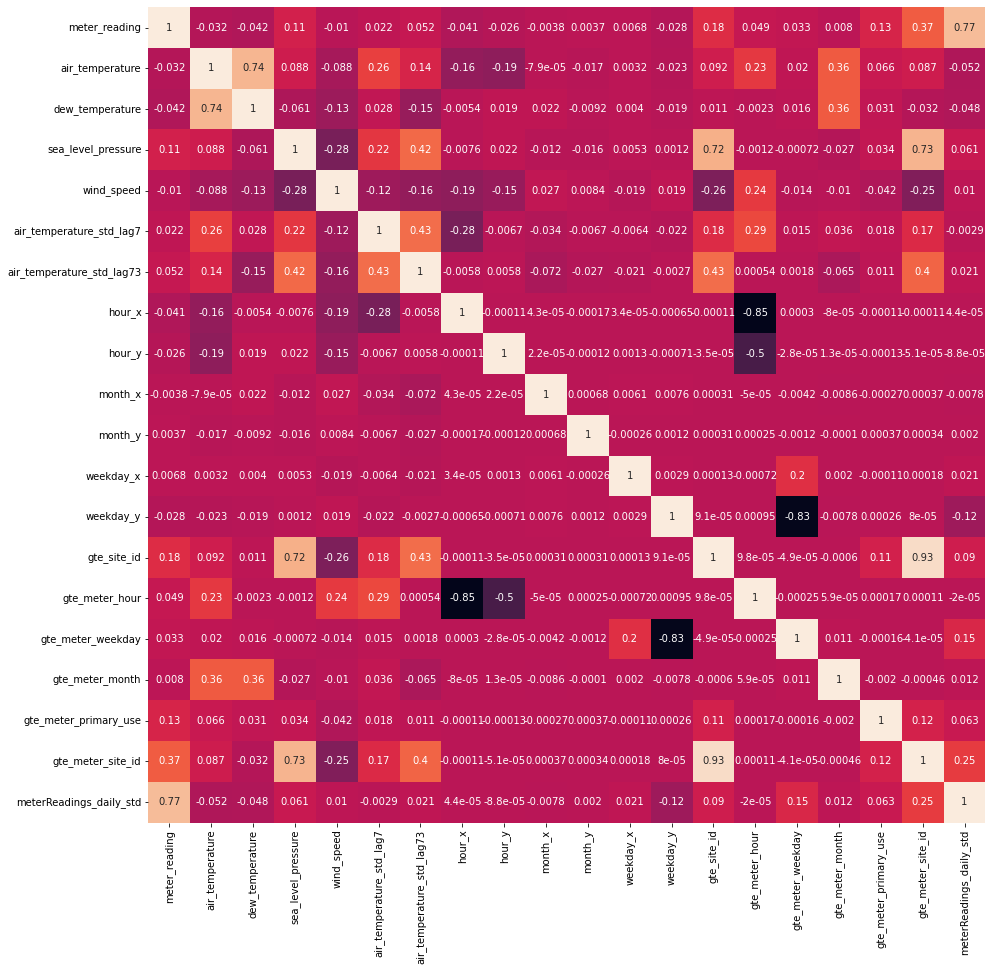

In [169]:
plt.figure(figsize=(15,15))
sb.heatmap(df_train[floats].corr(), annot=True, cbar=False)
plt.show()


/Users/sidan/opt/anaconda3/envs/classification/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/sidan/opt/anaconda3/envs/classification/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/sidan/opt/anaconda3/envs/classification/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

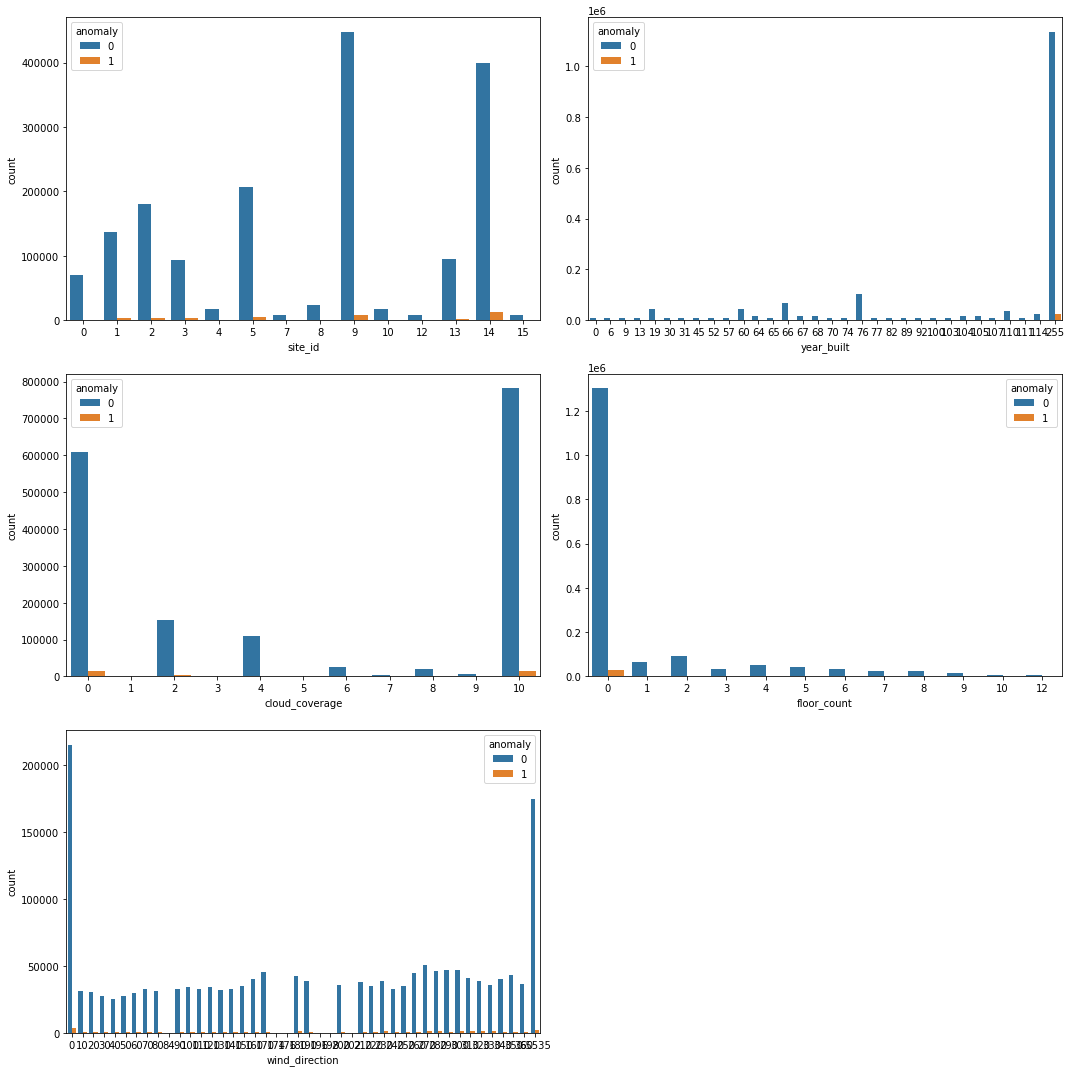

In [170]:
#this is taken from https://www.kaggle.com/code/patrick0302/2-anomaly-detection-features-csv-revised-ensem
#we see that the anomalies are occuring at specific site Ids, most (or all?) occuring for an unknown year, cloud coverage is none or unknown (255)
#also anomalies tend to occur with no floor count and is independent of wind direction
plt.subplots(figsize=(15,15))
sample = ['site_id', 'year_built', 'cloud_coverage', 'floor_count', 'wind_direction']

for i, col in enumerate(sample):
    plt.subplot(3,2,i+1)
    sb.countplot(df_train[col], hue=df_train['anomaly'])
plt.tight_layout()
plt.show()

/Users/sidan/opt/anaconda3/envs/classification/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/sidan/opt/anaconda3/envs/classification/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/sidan/opt/anaconda3/envs/classification/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

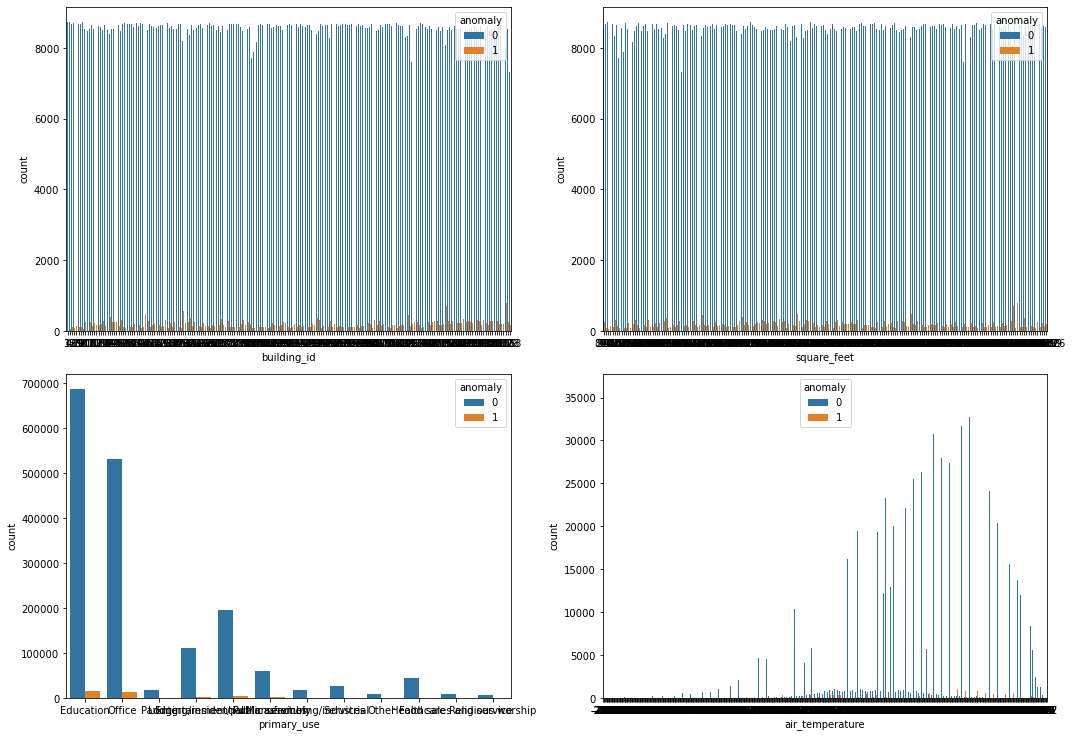

In [ ]:
plt.subplots(figsize=(15,15))
sample = ['building_id', 'square_feet', 'primary_use','air_temperature']

for i, col in enumerate(sample):
    plt.subplot(3,2,i+1)
    sb.countplot(df_train[col], hue=df_train['anomaly'])
plt.tight_layout()
plt.show()

In [69]:
#from Dave's office hours
le = preprocessing.LabelEncoder()
le.fit(df_train['primary_use'])
building_use_encoded= le.transform(df_train['primary_use'])
#will somehow need to apply this same thing to the test set, I'm still not sure how to do that

In [70]:
df_train_full=pd.concat([df_train,pd.Series(building_use_encoded)], axis=1)
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749494 entries, 0 to 1749493
Data columns (total 37 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   building_id                int64  
 1   meter_reading              float64
 2   anomaly                    int64  
 3   site_id                    int64  
 4   primary_use                object 
 5   square_feet                int64  
 6   year_built                 int64  
 7   floor_count                int64  
 8   air_temperature            float64
 9   cloud_coverage             int64  
 10  dew_temperature            float64
 11  precip_depth_1_hr          int64  
 12  sea_level_pressure         float64
 13  wind_direction             int64  
 14  wind_speed                 float64
 15  air_temperature_std_lag7   float64
 16  air_temperature_std_lag73  float64
 17  hour                       int64  
 18  weekday                    int64  
 19  month                      int64  
 20  we

In [19]:
df_train_full.value_counts(subset=[0,'primary_use'])

0   primary_use                  
0   Education                        700790
6   Office                           542577
1   Entertainment/public assembly    200345
4   Lodging/residential              114050
9   Public services                   61461
3   Healthcare                        43919
11  Services                          26306
5   Manufacturing/industrial          17568
8   Parking                           17568
2   Food sales and service             8784
7   Other                              8655
10  Religious worship                  7471
dtype: int64

In [20]:
df_train['anomaly'].value_counts()
 #37296/1712198 =0.0218 

0    1712198
1      37296
Name: anomaly, dtype: int64

In [71]:
df_train_full['meter_reading'] #107653/1749494 = 6.15% missing - do I remove or impute 

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
1749489     38.844
1749490    202.893
1749491        NaN
1749492    172.000
1749493      2.400
Name: meter_reading, Length: 1749494, dtype: float64

In [72]:
#imputing using the same method as the kaggle dataset (unclear if I impute on the hold out set separately??)

def impute_nulls(df_train_full):
    mean_reading = df_train_full.groupby('building_id').mean()['meter_reading']

    building_id = mean_reading.index
    values = mean_reading.values
    
    for i, idx in tqdm(enumerate(building_id)):
        df_train_full[df_train_full['building_id']==idx] = df_train_full[df_train_full['building_id']==idx].fillna(values[i]) 
    
    return df_train_full

df_train_full = impute_nulls(df_train_full)


200it [00:08, 24.23it/s]


In [73]:
df_train2 = df_train_full[df_train_full['building_id']<1242]

In [286]:
df_train2.value_counts('building_id')

building_id
1       8784
687     8784
721     8784
710     8784
708     8784
        ... 
909     8466
848     8351
844     7959
827     7799
1232    7779
Length: 160, dtype: int64

In [74]:
df_val = df_train_full[df_train_full['building_id']>=1242] #20% split (will need to change when I add more data)

In [ ]:
for_hist=pd.DataFrame(df_train_full['meter_reading'].isnull().groupby(df_train_full.building_id).sum())


In [ ]:
for_hist['meter_reading'] =for_hist['meter_reading'].astype(int)

array([[<AxesSubplot:title={'center':'meter_reading'}>]], dtype=object)

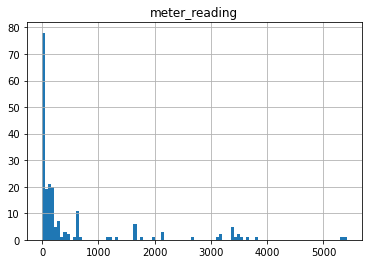

In [ ]:
for_hist.hist('meter_reading',bins=100) #most buildings only have a few 100but several have a few 1000readings that are NA

In [ ]:
pd.DataFrame(df_train_full['meter_reading'].isnull().groupby(df_train_full.anomaly).sum()) #no anomalies have NA meter readings, so would the 6% extra with imputations help?


,meter_reading
anomaly,
0,107653
1,0


In [76]:
df_train2_x = df_train2.drop(['anomaly','building_id', 'site_id','primary_use','weekday_hour','date','weekday'], axis=1)
df_val_x = df_val.drop(['anomaly','building_id', 'site_id','primary_use','weekday_hour','date','weekday'], axis=1)

In [103]:
df_train2_x = df_train2.drop(['month', 'hour'], axis=1)
df_val_x = df_val.drop(['month','hour'], axis=1)